In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from tqdm import tqdm
import os
import datetime
import matplotlib.dates as mdates
from chinese_calendar import is_holiday, is_workday
from scipy import stats

In [2]:
stationInfo = pd.read_csv('../Data/stationInfo.csv')
dict_staionName = dict(zip(stationInfo['stationID'], stationInfo['name']))
dict_stationLoc = dict(zip(stationInfo['stationID'], zip(stationInfo['lon'],stationInfo['lat'])))
stationID_List = list(stationInfo['stationID'])

root_path = '../Data' 
raw_data = pd.read_csv(os.path.join(root_path, 'metroData_InOutFlow.csv'))
raw_data

,date,timeslot,startTime,endTime,station,inFlow,outFlow,CinFlow,HBOinFlow,NHBinFlow,CoutFlow,HBOoutFlow,NHBoutFlow
0,20170501,0,60000,61000,112,29,32,9,15,5,11,13,8
1,20170501,0,60000,61000,113,142,102,40,51,51,30,41,31
2,20170501,0,60000,61000,114,66,35,17,19,30,12,10,13
3,20170501,0,60000,61000,119,23,14,6,9,8,1,3,10
4,20170501,0,60000,61000,124,17,21,2,4,11,0,9,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3788887,20170831,12545,225000,230000,2053,6,26,2,0,4,8,6,12
3788888,20170831,12545,225000,230000,2054,18,110,5,2,11,19,39,52
3788889,20170831,12545,225000,230000,2055,5,80,0,1,4,19,23,38
3788890,20170831,12545,225000,230000,2056,33,99,8,4,21,20,31,48


In [3]:
totalFlow = [] # 线网总流量（每天）
dayList = []

curr_date = 20170501
currDayFlow = 0
for line in tqdm(raw_data.values):
    if curr_date != line[0]:
        totalFlow.append(currDayFlow)
        dayList.append(curr_date)
        curr_date = line [0]
        
        currDayFlow = 0

    currDayFlow += line[5]

totalFlow.append(currDayFlow)#每一天的总流入量，记得加上最后一天
dayList.append(curr_date)
totalFlow = np.array(totalFlow)

100%|██████████| 3788892/3788892 [00:03<00:00, 1230767.70it/s]


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33332\4149477291.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)


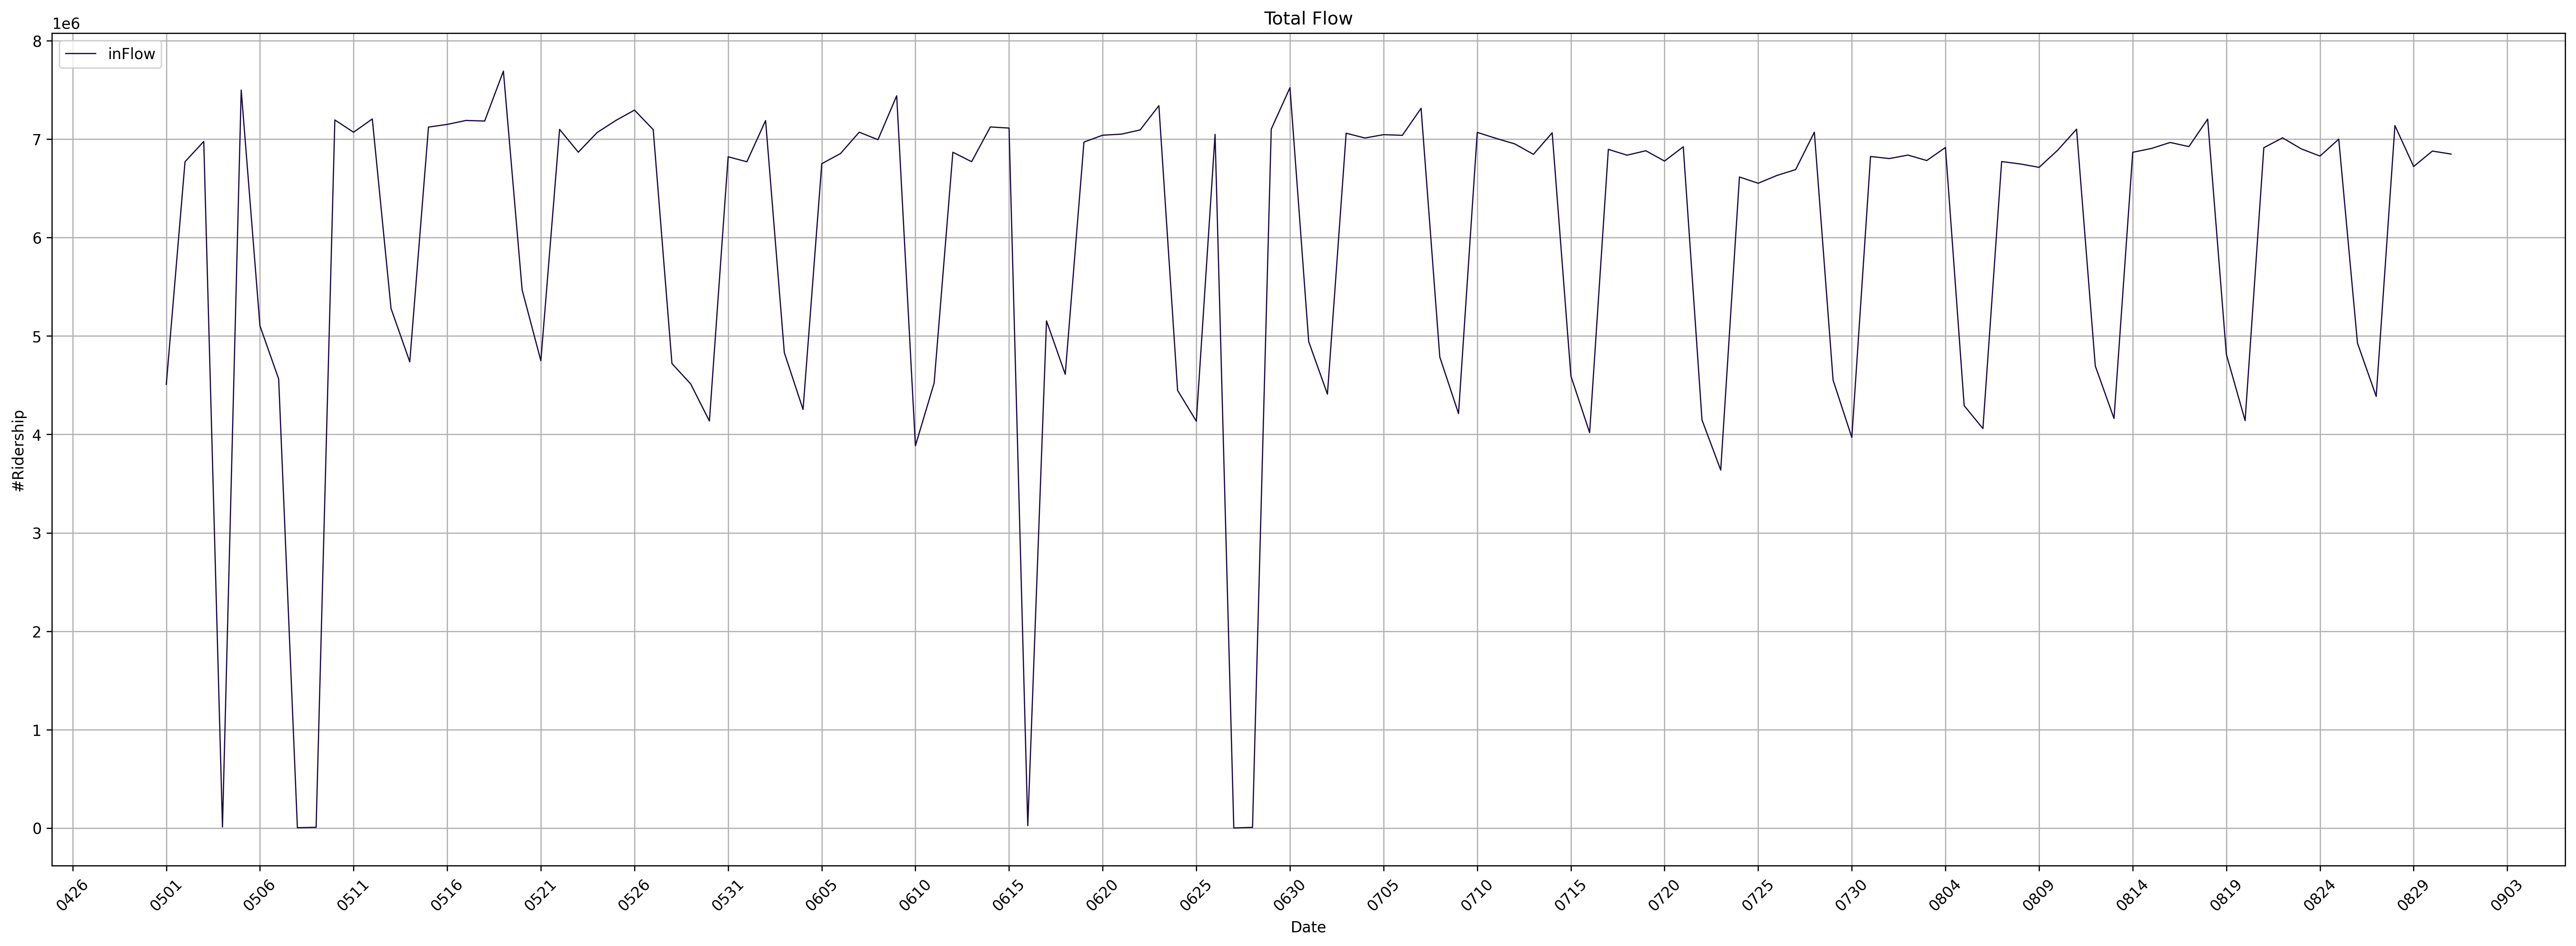

In [4]:
mydates = pd.date_range(start=datetime.datetime.strptime('20170501',"%Y%m%d"), end=datetime.datetime.strptime('20170831',"%Y%m%d"), freq="1D")

fig, ax1 = plt.subplots(1, 1, figsize=(30, 10), dpi=300)

ax1.plot(mydates, totalFlow, label='inFlow', linewidth=0.8, color=(26/255,8/255,65/255))
ax1.set_title('Total Flow')
ax1.set_xlabel('Date')
ax1.set_ylabel('#Ridership')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m%d'))  
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=5))  
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
ax1.legend(loc='upper left')
ax1.grid()

In [5]:
workdayIdxList = [] # idx for date in dayList
holidayIdxList = []
for idx, tF in enumerate(totalFlow):
    if tF< 2*1e6:
        print(dayList[idx])
        continue#排除流量异常低的日期
    elif is_workday(datetime.datetime.strptime(str(dayList[idx]),'%Y%m%d')):
        workdayIdxList.append(idx)
    else:
        holidayIdxList.append(idx)
print(len(workdayIdxList))
print(len(holidayIdxList))

20170504
20170508
20170509
20170616
20170627
20170628
81
36


In [6]:
def corrWithWeather(totalFlow, workdayIdxList, holidayIdxList, dayList):
    weatherData = pd.read_csv('../Data/MetaData/shanghai_weatherDaily.csv')

    day2Rain =  dict(zip(weatherData['date'], (weatherData['rain_sum'] > 0).astype(int)))
    day2Temp =  dict(zip(weatherData['date'], weatherData['temperature_2m_mean']))

    workdayFlow = [totalFlow[i] for i in workdayIdxList]
    holidayFlow = [totalFlow[i] for i in holidayIdxList]

    # Rain
    workdayRain = [day2Rain[dayList[idx]] for idx in workdayIdxList]
    holidayRain = [day2Rain[dayList[idx]] for idx in holidayIdxList]
    r_workday, p_workday = stats.pointbiserialr(workdayRain, workdayFlow) # Point-biserial correlation
    r_holiday, p_holiday = stats.pointbiserialr(holidayRain, holidayFlow)
    print('for workday flow and rain, r={}, p={}'.format(r_workday, p_workday))
    print('for holiday flow and rain, r={}, p={}'.format(r_holiday, p_holiday))

    workdayFlowbox = [[],[]]
    for idx, flow in enumerate(workdayFlow):
        workdayFlowbox[workdayRain[idx]].append(flow)

    holidayFlowbox = [[],[]]
    for idx, flow in enumerate(holidayFlow):
        holidayFlowbox[holidayRain[idx]].append(flow)

    fig, axis = plt.subplots(2,2, figsize=(10, 10), dpi=300)
    axis[0,0].boxplot(x=workdayFlowbox,tick_labels =[0,1] ,patch_artist=False, showfliers=False,showmeans=False, medianprops=dict(linewidth=0), zorder=0)
    for i, data in enumerate(workdayFlowbox): # draw datapoints
        x_positions = np.random.uniform(i+0.95, i+1.05, size=len(data))  
        axis[0,0].scatter(x_positions, data, color='black', alpha=0.3, s=1, zorder=1) 
    axis[0,0].set_title('Workday')
    axis[0,0].set_xlabel('isRainy')
    axis[0,0].set_ylabel('#Ridership')
    axis[0,0].text(0.95, 0.05, 'corr='+str(round(r_workday,2)),ha='right',va='bottom',transform=axis[0,0].transAxes)

    axis[0,1].boxplot(x=holidayFlowbox,tick_labels =[0,1] ,patch_artist=False, showfliers=False,showmeans=False, medianprops=dict(linewidth=0), zorder=0)
    for i, data in enumerate(holidayFlowbox): # draw datapoints
        x_positions = np.random.uniform(i+0.95, i+1.05, size=len(data))  
        axis[0,1].scatter(x_positions, data, color='black', alpha=0.3, s=1, zorder=1) 
    axis[0,1].set_title('Holiday')
    axis[0,1].set_xlabel('isRainy')
    axis[0,1].set_ylabel('#Ridership')
    axis[0,1].text(0.95, 0.05, 'corr='+str(round(r_holiday,2)),ha='right',va='bottom',transform=axis[0,1].transAxes)

    # Temp 
    workdayTemp = [day2Temp[dayList[idx]] for idx in workdayIdxList]
    holidayTemp = [day2Temp[dayList[idx]] for idx in holidayIdxList]
    corr_workdayTemp = np.corrcoef(workdayFlow, workdayTemp)[0,1]
    corr_holidayTemp = np.corrcoef(holidayFlow, holidayTemp)[0,1]
    axis[1,0].scatter(workdayTemp,workdayFlow, s=10, facecolor='green', edgecolors='black', linewidths=0.5)
    axis[1,0].set_ylabel('#Ridership')
    axis[1,0].set_xlabel('Temperature')
    axis[1,0].spines['top'].set_visible(False)
    axis[1,0].spines['right'].set_visible(False)
    axis[1,0].text(0.95, 0.8, 'corr='+str(round(corr_workdayTemp,2)),ha='right',va='bottom',transform=axis[1,0].transAxes)
    coefficients = np.polyfit(workdayTemp,workdayFlow, 1)  
    poly = np.poly1d(coefficients)
    x_reg = np.array([min(workdayTemp), max(workdayTemp)])  
    axis[1,0].plot(x_reg, poly(x_reg), 'r-',zorder=0)  

    axis[1,1].scatter(holidayTemp,holidayFlow, s=10, facecolor='green', edgecolors='black', linewidths=0.5)
    axis[1,1].set_ylabel('#Ridership')
    axis[1,1].set_xlabel('Temperature')
    axis[1,1].spines['top'].set_visible(False)
    axis[1,1].spines['right'].set_visible(False)
    axis[1,1].text(0.95, 0.8, 'corr='+str(round(corr_holidayTemp,2)),ha='right',va='bottom',transform=axis[1,1].transAxes)
    coefficients = np.polyfit(holidayTemp,holidayFlow, 1)  
    poly = np.poly1d(coefficients)
    x_reg = np.array([min(holidayTemp), max(holidayTemp)])  
    axis[1,1].plot(x_reg, poly(x_reg), 'r-', zorder=0)  



for workday flow and rain, r=-0.18969498493512243, p=0.08985610289445692
for holiday flow and rain, r=-0.4858204727370033, p=0.00266640729275705


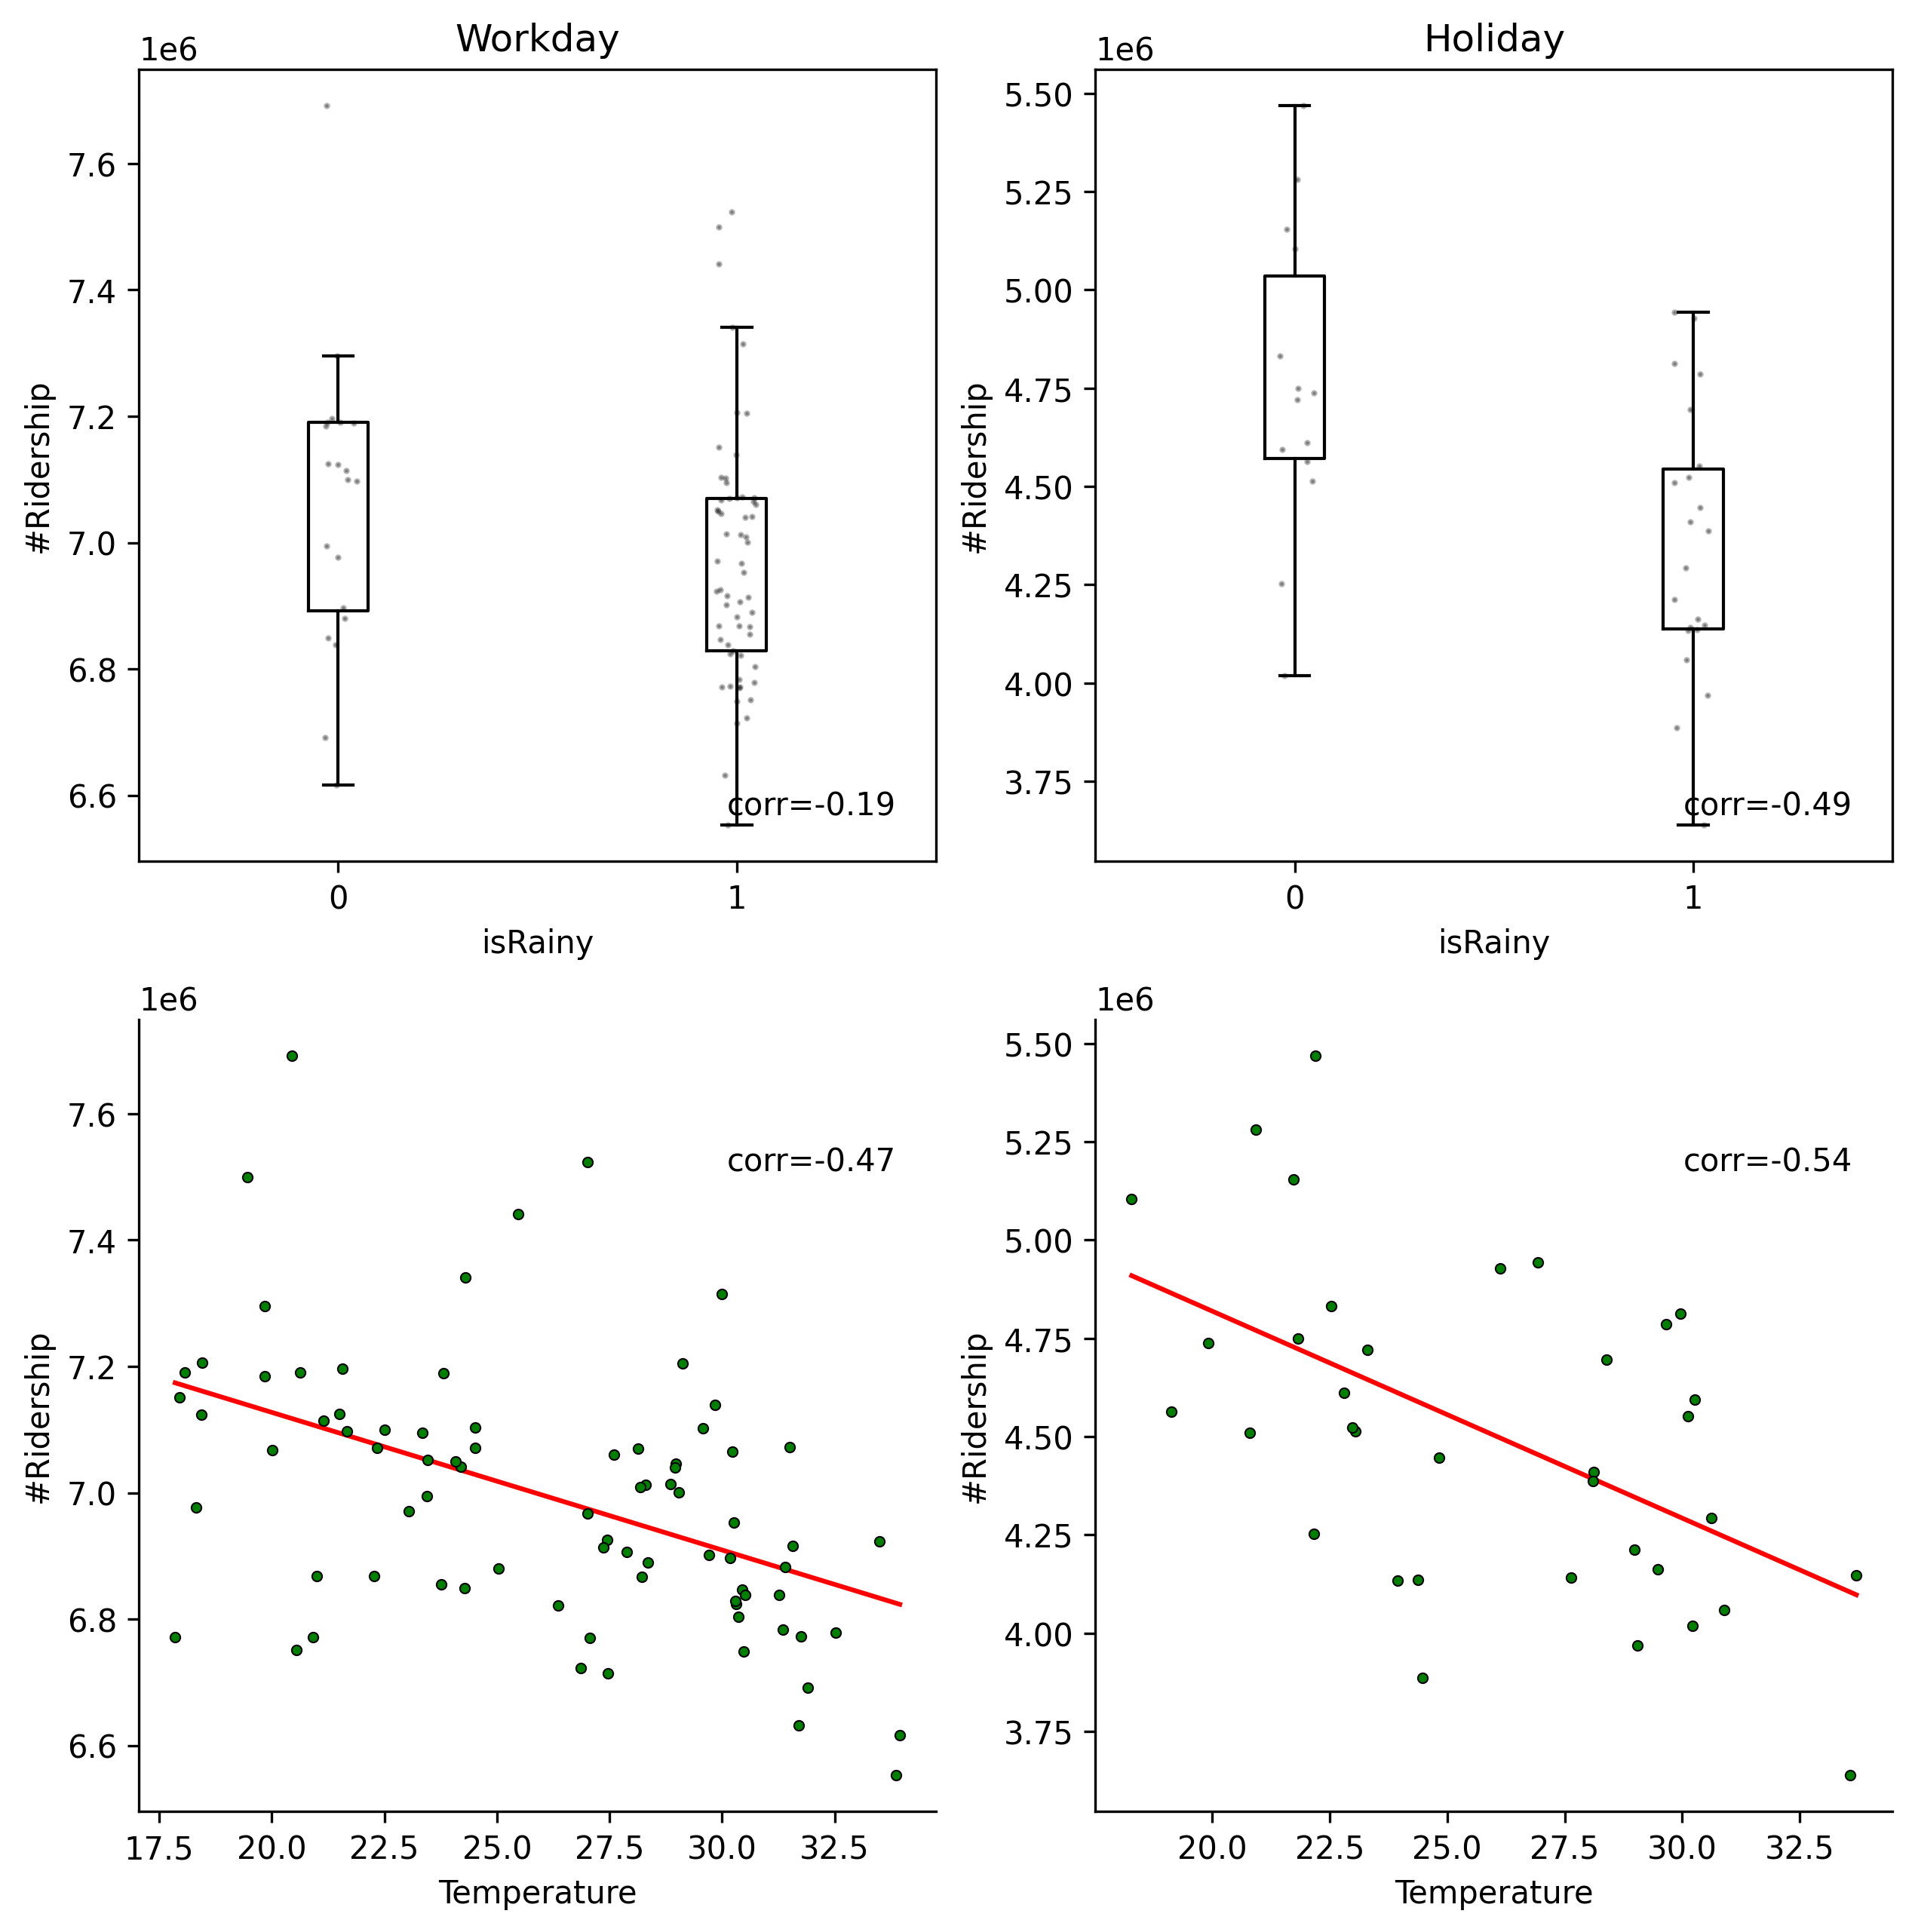

In [7]:
corrWithWeather(totalFlow, workdayIdxList, holidayIdxList, dayList)

# 这段代码的作用是分析地铁客流量与天气因素（降雨和温度）的相关性
# 
# 相关系数解释：
# 1. 降雨相关性（点双列相关系数）：
#    - 工作日：r = -0.19, p = 0.090 
#      含义：下雨时地铁客流量轻微减少，但统计上不显著（p > 0.05）
#    - 节假日：r = -0.49, p = 0.003
#      含义：下雨时地铁客流量显著减少，统计上高度显著（p < 0.01）
#
# 2. 温度相关性（皮尔逊相关系数）：
#    - 工作日：r = -0.47
#      含义：温度升高时地铁客流量减少，中等强度负相关
#    - 节假日：r = -0.54  
#      含义：温度升高时地铁客流量减少，中等偏强负相关
#
# 相关系数范围：-1到+1
# - 负值：负相关（一个增加，另一个减少）
# - 正值：正相关（一个增加，另一个也增加）  
# - 0：无线性相关
# - |r| > 0.7：强相关，0.3-0.7：中等相关，< 0.3：弱相关
#
# 实际意义：
# 1. 下雨对节假日出行影响更大（人们可选择不出门）
# 2. 工作日受雨天影响较小（通勤刚需）
# 3. 高温天气下，无论工作日还是节假日，人们都倾向减少地铁出行